## 1. Imports & Dependencies

In [32]:
"""
Credit Card Fraud Detection
============================================

1. Upload your CSV directly in Colab
2. Split FIRST, then resample only the training set (no data leakage)
3. SMOTE applied only to training data — test set stays imbalanced (realistic)
4. scale_pos_weight reflects true class imbalance
5. Early stopping on a proper validation set
6. Train vs test metrics shown side-by-side to detect overfitting
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import joblib
import warnings

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
)
import xgboost as xgb
from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")
print("Libraries loaded successfully!")


Libraries loaded successfully!


## 2. Configuration — Edit paths/settings here

In [33]:
# ============================================================
# CONFIGURATION — edit these to match your CSV
# ============================================================
TARGET_COLUMN   = "Class"  # Name of the fraud label column (0 = legit, 1 = fraud)
COLUMNS_TO_DROP = []       # Any columns to ignore e.g. ["id", "Time"]

# At extreme imbalance (500:1+), SMOTE floods the model with synthetic points
# and causes early stopping to fire too soon. Disabled here — XGBoost handles
# imbalance natively and more robustly via scale_pos_weight.
USE_SMOTE  = True
SMOTE_RATIO = 0.05   # Only used if USE_SMOTE = True


## 3. FraudDetectionModel Class

In [34]:
# ============================================================
# CLASS DEFINITION
# ============================================================
class FraudDetectionModel:
    """
    XGBoost-based fraud detection with correct imbalance handling.

    The golden rule: SPLIT FIRST, then resample only the training set.
    The test set must always reflect the real-world class distribution.
    """

    def __init__(self, use_smote=True, smote_sampling_strategy=0.1):
        """
        Parameters
        ----------
        use_smote : bool
            Apply SMOTE to training set. If False, use scale_pos_weight only.
        smote_sampling_strategy : float
            Target fraud ratio after SMOTE (e.g. 0.1 = 10% fraud in training).
            Keep this moderate — you don't need 50/50 for XGBoost to work well.
        """
        self.use_smote = use_smote
        self.smote_sampling_strategy = smote_sampling_strategy
        self.scaler = StandardScaler()
        self.model = None
        self.best_threshold = 0.5

    # ----------------------------------------------------------
    # FIX 1: Split FIRST on the raw, imbalanced data
    # ----------------------------------------------------------
    def prepare_data(self, X, y, test_size=0.2, random_state=42):
        """
        Stratified train/test split on the RAW data.
        The test set is never touched by any resampling.
        """
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=test_size,
            random_state=random_state,
            stratify=y,          # preserves real fraud ratio in both splits
        )

        # Scale using only training statistics — no leakage
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)   # transform only, never fit

        print(f"Training set : {len(X_train):,} samples  |  "
              f"Fraud rate: {y_train.mean()*100:.2f}%")
        print(f"Test set     : {len(X_test):,} samples  |  "
              f"Fraud rate: {y_test.mean()*100:.2f}%")

        return X_train_scaled, X_test_scaled, y_train, y_test

    # ----------------------------------------------------------
    # FIX 2: Apply SMOTE ONLY inside train(), never before split
    # ----------------------------------------------------------
    def train(self, X_train, y_train, X_val=None, y_val=None):
        """
        Train XGBoost with correct imbalance handling.

        For extreme imbalance (100:1+) SMOTE is often counterproductive —
        it floods the model with synthetic points and causes early stopping
        to fire prematurely. scale_pos_weight is XGBoost's native, more
        robust solution: it upweights the loss on minority-class samples
        without changing the data distribution.
        """
        n_fraud = np.sum(y_train == 1)
        n_legit = np.sum(y_train == 0)
        scale_pos_weight = n_legit / n_fraud

        print(f"\nTraining class distribution:")
        print(f"  Legitimate: {n_legit:,}  |  Fraud: {n_fraud:,}  "
              f"  |  Imbalance ratio: {scale_pos_weight:.1f}x")

        X_fit, y_fit = X_train, y_train

        if self.use_smote:
            print(f"\nApplying SMOTE to training set only "
                  f"(target fraud ratio: {self.smote_sampling_strategy:.0%})...")
            smote = SMOTE(
                sampling_strategy=self.smote_sampling_strategy,
                random_state=42,
                k_neighbors=5,
            )
            X_fit, y_fit = smote.fit_resample(X_train, y_train)
            print(f"After SMOTE — Legitimate: {np.sum(y_fit==0):,}  |  "
                  f"Fraud: {np.sum(y_fit==1):,}")
            # SMOTE already rebalanced — don't double-correct with scale_pos_weight
            effective_spw = 1
        else:
            # Native XGBoost imbalance handling — preferred for extreme ratios
            effective_spw = scale_pos_weight
            print(f"  Using scale_pos_weight={effective_spw:.1f} "
                  f"(no SMOTE — XGBoost handles imbalance natively)")

        params = {
            "max_depth": 6,
            "learning_rate": 0.05,
            "n_estimators": 1000,         # higher ceiling — early stopping controls it
            "objective": "binary:logistic",
            "eval_metric": "aucpr",       # PR-AUC: best for imbalanced data
            "scale_pos_weight": effective_spw,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "min_child_weight": 5,
            "gamma": 1,
            "reg_alpha": 0.1,
            "reg_lambda": 1.0,
            "random_state": 42,
            "n_jobs": -1,
            "tree_method": "hist",
            "early_stopping_rounds": 50,  # more patience — model trains longer
        }

        self.model = xgb.XGBClassifier(**params)

        if X_val is not None:
            eval_set = [(X_fit, y_fit), (X_val, y_val)]
        else:
            X_fit, X_es, y_fit, y_es = train_test_split(
                X_fit, y_fit, test_size=0.15,
                stratify=y_fit, random_state=42
            )
            eval_set = [(X_fit, y_fit), (X_es, y_es)]

        print("\nTraining XGBoost model...")
        self.model.fit(X_fit, y_fit, eval_set=eval_set, verbose=False)

        print(f"Training complete! Best iteration: {self.model.best_iteration}")
        return self

    # ----------------------------------------------------------
    # FIX 5: Report both train AND test metrics to spot overfitting
    # ----------------------------------------------------------
    def evaluate(self, X_test, y_test, X_train=None, y_train=None, threshold=None):
        """
        Evaluate on the test set. Optionally compare against training metrics
        so you can detect overfitting at a glance.
        """
        if threshold is None:
            threshold = self.best_threshold

        def _metrics(X, y, label):
            proba = self.model.predict_proba(X)[:, 1]
            pred = (proba >= threshold).astype(int)
            return {
                "label":     label,
                "precision": precision_score(y, pred, zero_division=0),
                "recall":    recall_score(y, pred, zero_division=0),
                "f1":        f1_score(y, pred, zero_division=0),
                "roc_auc":   roc_auc_score(y, proba),
                "pr_auc":    average_precision_score(y, proba),
                "proba":     proba,
                "pred":      pred,
            }

        test_m = _metrics(X_test, y_test, "TEST ")

        print("\n" + "=" * 60)
        print("MODEL EVALUATION RESULTS")
        print("=" * 60)
        print(f"\nUsing threshold: {threshold:.3f}")

        # Confusion matrix
        cm = confusion_matrix(y_test, test_m["pred"])
        tn, fp, fn, tp = cm.ravel()
        print(f"\nConfusion Matrix (Test Set):")
        print(f"  True Negatives:  {tn:7,}  |  False Positives: {fp:7,}")
        print(f"  False Negatives: {fn:7,}  |  True Positives:  {tp:7,}")

        # Side-by-side comparison if training metrics requested
        rows = [test_m]
        if X_train is not None:
            train_m = _metrics(X_train, y_train, "TRAIN")
            rows.insert(0, train_m)

        print(f"\n{'Metric':<18}", end="")
        for r in rows:
            print(f"  {r['label']:>8}", end="")
        print()
        print("-" * (18 + 10 * len(rows)))

        for metric in ["precision", "recall", "f1", "roc_auc", "pr_auc"]:
            label_map = {
                "precision": "Precision",
                "recall": "Recall",
                "f1": "F1 Score",
                "roc_auc": "ROC-AUC",
                "pr_auc": "PR-AUC",
            }
            print(f"{label_map[metric]:<18}", end="")
            for r in rows:
                print(f"  {r[metric]:>8.4f}", end="")
            print()

        if len(rows) == 2:
            print("\n[Overfitting check] Large gap between TRAIN and TEST = overfitting.")
            print("[Underfitting check] Both scores low = model too simple or bad features.")

        # Business metrics
        fraud_catch_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
        false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
        print(f"\nBusiness Metrics (Test Set):")
        print(f"  Fraud Catch Rate : {fraud_catch_rate:.2%}")
        print(f"  False Alarm Rate : {false_alarm_rate:.2%}")

        print("\nDetailed Classification Report (Test Set):")
        print(classification_report(
            y_test, test_m["pred"],
            target_names=["Legitimate", "Fraud"],
            digits=4,
        ))

        return test_m

    def optimize_threshold(self, X_val, y_val, metric="f2"):
        """
        Find optimal classification threshold using a VALIDATION set (not test set).

        Scans every percentile of the predicted probability distribution so the
        search is always dense where predictions actually live — critical for
        heavily imbalanced data where almost all scores cluster near 0.
        """
        proba = self.model.predict_proba(X_val)[:, 1]

        # Use percentiles of actual predictions instead of a fixed grid.
        # This guarantees dense coverage in the region that matters.
        percentile_thresholds = np.percentile(proba, np.arange(1, 100, 0.5))
        fixed_thresholds      = np.arange(0.01, 0.99, 0.005)
        thresholds = np.unique(np.concatenate([percentile_thresholds, fixed_thresholds]))
        thresholds = thresholds[(thresholds > 0) & (thresholds < 1)]

        scores = []
        for t in thresholds:
            pred = (proba >= t).astype(int)
            if metric == "f1":
                scores.append(f1_score(y_val, pred, zero_division=0))
            elif metric == "f2":
                # F2 weights recall 2x more than precision — right trade-off for fraud
                scores.append(f1_score(y_val, pred, beta=2, zero_division=0))
            elif metric == "recall":
                # Maximise recall subject to precision > 0 (catches the most fraud)
                p = precision_score(y_val, pred, zero_division=0)
                r = recall_score(y_val, pred, zero_division=0)
                scores.append(r if p > 0 else 0)

        best_idx = int(np.argmax(scores))
        self.best_threshold = float(thresholds[best_idx])

        # Show the precision / recall at this threshold for transparency
        pred_best = (proba >= self.best_threshold).astype(int)
        p_best = precision_score(y_val, pred_best, zero_division=0)
        r_best = recall_score(y_val, pred_best, zero_division=0)

        print(f"\nOptimal threshold ({metric}): {self.best_threshold:.4f}")
        print(f"  Score ({metric})  : {scores[best_idx]:.4f}")
        print(f"  Precision        : {p_best:.4f}")
        print(f"  Recall           : {r_best:.4f}")
        print(f"  (Threshold scan covered {len(thresholds)} points "
              f"from {thresholds.min():.4f} to {thresholds.max():.4f})")
        return self.best_threshold

    def cross_validate(self, X_train, y_train, n_splits=5):
        """
        Stratified k-fold CV on training data only.
        Confirms the model generalizes within the training distribution.
        """
        print(f"\nRunning {n_splits}-fold Stratified Cross-Validation on training set...")
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

        # Use a lightweight model for CV speed
        cv_model = xgb.XGBClassifier(
            max_depth=6, learning_rate=0.05, n_estimators=200,
            objective="binary:logistic", eval_metric="aucpr",
            scale_pos_weight=np.sum(y_train == 0) / np.sum(y_train == 1),
            subsample=0.8, colsample_bytree=0.8,
            random_state=42, n_jobs=-1, tree_method="hist",
        )

        scores = cross_val_score(cv_model, X_train, y_train,
                                 cv=cv, scoring="roc_auc", n_jobs=-1)
        print(f"CV ROC-AUC scores: {scores}")
        print(f"Mean: {scores.mean():.4f}  |  Std: {scores.std():.4f}")
        print("(High std across folds can indicate instability/overfitting)")
        return scores

    def plot_results(self, X_test, y_test):
        """Visualize model performance."""
        proba = self.model.predict_proba(X_test)[:, 1]
        pred = (proba >= self.best_threshold).astype(int)

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle("Fraud Detection Model — Evaluation Results", fontsize=16, fontweight="bold")

        # 1. Precision-Recall Curve
        p, r, _ = precision_recall_curve(y_test, proba)
        pr_auc = average_precision_score(y_test, proba)
        baseline = y_test.mean()
        axes[0, 0].plot(r, p, linewidth=2, label=f"PR-AUC = {pr_auc:.4f}")
        axes[0, 0].axhline(baseline, color="red", linestyle="--",
                           label=f"No-skill baseline ({baseline:.3f})")
        axes[0, 0].set_xlabel("Recall")
        axes[0, 0].set_ylabel("Precision")
        axes[0, 0].set_title("Precision-Recall Curve")
        axes[0, 0].legend()
        axes[0, 0].grid(alpha=0.3)

        # 2. Confusion Matrix
        cm = confusion_matrix(y_test, pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0, 1],
                    xticklabels=["Legitimate", "Fraud"],
                    yticklabels=["Legitimate", "Fraud"])
        axes[0, 1].set_ylabel("True Label")
        axes[0, 1].set_xlabel("Predicted Label")
        axes[0, 1].set_title("Confusion Matrix")

        # 3. Feature Importance (top 20)
        importance = self.model.feature_importances_
        idx = np.argsort(importance)[::-1][:20]
        axes[1, 0].barh(range(len(idx)), importance[idx])
        axes[1, 0].set_yticks(range(len(idx)))
        axes[1, 0].set_yticklabels([f"Feature {i}" for i in idx])
        axes[1, 0].set_xlabel("Importance")
        axes[1, 0].set_title("Top 20 Feature Importances")
        axes[1, 0].invert_yaxis()

        # 4. Score Distribution
        axes[1, 1].hist(proba[y_test == 0], bins=60, alpha=0.6,
                        label="Legitimate", color="steelblue")
        axes[1, 1].hist(proba[y_test == 1], bins=60, alpha=0.6,
                        label="Fraud", color="crimson")
        axes[1, 1].axvline(self.best_threshold, color="green", linestyle="--",
                           linewidth=2, label=f"Threshold = {self.best_threshold:.3f}")
        axes[1, 1].set_xlabel("Predicted Probability")
        axes[1, 1].set_ylabel("Frequency (log scale)")
        axes[1, 1].set_yscale("log")
        axes[1, 1].set_title("Score Distribution by Class")
        axes[1, 1].legend()

        plt.tight_layout()
        plt.savefig("fraud_detection_results.png", dpi=300, bbox_inches="tight")
        print("\nPlot saved as 'fraud_detection_results.png'")

    def save_model(self, filepath="./fraud_model.pkl"):
        joblib.dump({"model": self.model, "scaler": self.scaler,
                     "threshold": self.best_threshold}, filepath)
        print(f"\nModel saved to {filepath}")

    def load_model(self, filepath="./fraud_model.pkl"):
        data = joblib.load(filepath)
        self.model = data["model"]
        self.scaler = data["scaler"]
        self.best_threshold = data["threshold"]
        print(f"Model loaded from {filepath}")




In [35]:
# ============================================================
# FEATURE ENGINEERING
# ============================================================
# The 15 missed fraud cases score < 0.39 — the model sees them as
# legitimate because V1-V28 PCA features alone don't distinguish them.
# Adding behavioural features from Amount and Time exposes new signal.
#
# Run this AFTER Step 0 (upload) and BEFORE Step 2 (instantiate model).
# It modifies the global `df` in place.
# ============================================================

import numpy as np

def engineer_features(df, target_col="Class", verbose=True):
    """
    Add interpretable features derived from Amount and Time.
    All features are computed on the full dataset before the train/test split
    — only transformations that don't use label information are applied here,
    so there is no leakage.
    """
    df = df.copy()

    # ── Amount features ──────────────────────────────────────
    # Log-transform tames the heavy right skew in transaction amounts.
    # Fraud transactions are often unusually small (testing the card)
    # or unusually large — log scale makes both ends more visible.
    df["Amount_log"] = np.log1p(df["Amount"])

    # Squared term captures non-linear amount effects
    df["Amount_sq"] = df["Amount"] ** 2

    # Round-number flag: fraudsters often test with round amounts (50.00, 100.00)
    df["Amount_is_round"] = (df["Amount"] % 1 == 0).astype(int)

    # Very small amount flag (< $1) — common card-testing pattern
    df["Amount_tiny"] = (df["Amount"] < 1.0).astype(int)

    # ── Time features ─────────────────────────────────────────
    # Time is seconds elapsed — convert to hour-of-day (0–23).
    # Fraud patterns often cluster at unusual hours (late night / early morning).
    if "Time" in df.columns:
        df["Hour"] = (df["Time"] // 3600) % 24

        # Is the transaction in a high-risk time window?
        # Hours 0–5 (late night) see disproportionate fraud in many datasets.
        df["Hour_is_night"] = df["Hour"].between(0, 5).astype(int)

        # Sine/cosine encoding preserves the cyclic nature of hour
        # (so hour 23 and hour 0 are "close", not "far apart")
        df["Hour_sin"] = np.sin(2 * np.pi * df["Hour"] / 24)
        df["Hour_cos"] = np.cos(2 * np.pi * df["Hour"] / 24)

        # ── Interaction features ──────────────────────────────────
        # Amount × night: large late-night transactions are higher risk
        df["Amount_x_night"] = df["Amount_log"] * df["Hour_is_night"]

        # ── Drop raw Time (replaced by engineered hour features) ──
        # Keep Amount raw — Amount_log is added alongside it, not instead.
        df = df.drop(columns=["Time"], errors="ignore")

    # V1 and V3 are typically the strongest PCA fraud signals in this dataset.
    # Their interaction can capture fraud patterns neither catches alone.
    if "V1" in df.columns and "V3" in df.columns:
        df["V1_x_V3"] = df["V1"] * df["V3"]
    if "V1" in df.columns and "V4" in df.columns:
        df["V1_x_V4"] = df["V1"] * df["V4"]
    if "V2" in df.columns and "V5" in df.columns:
        df["V2_x_V5"] = df["V2"] * df["V5"]

    if verbose:
        # Updated new_cols to reflect that Time related features might not be present
        # if 'Time' column was already dropped or never existed.
        new_cols_potential = ["Amount_log", "Amount_sq", "Amount_is_round", "Amount_tiny",
                              "Hour", "Hour_is_night", "Hour_sin", "Hour_cos",
                              "Amount_x_night", "V1_x_V3", "V1_x_V4", "V2_x_V5"]
        new_cols = [c for c in new_cols_potential if c in df.columns]

        print(f"Feature engineering complete.")
        print(f"New features added ({len(new_cols)}): {new_cols}")
        print(f"Final dataframe shape: {df.shape}")

    return df


# Apply to the uploaded dataframe
df = engineer_features(df, target_col=TARGET_COLUMN)

# Preview new features
print("\nSample of engineered features:")
new_feat_cols = ["Amount", "Amount_log", "Amount_is_round", "Amount_tiny",
                 "Hour", "Hour_is_night", "Hour_sin", "Hour_cos", "Amount_x_night"]
print(df[[c for c in new_feat_cols if c in df.columns]].describe().round(3))

Feature engineering complete.
New features added (12): ['Amount_log', 'Amount_sq', 'Amount_is_round', 'Amount_tiny', 'Hour', 'Hour_is_night', 'Hour_sin', 'Hour_cos', 'Amount_x_night', 'V1_x_V3', 'V1_x_V4', 'V2_x_V5']
Final dataframe shape: (284807, 42)

Sample of engineered features:
           Amount  Amount_log  Amount_is_round  Amount_tiny        Hour  \
count  284807.000  284807.000       284807.000   284807.000  284807.000   
mean       88.350       3.152            0.249        0.059      14.046   
std       250.120       1.657            0.432        0.236       5.836   
min         0.000       0.000            0.000        0.000       0.000   
25%         5.600       1.887            0.000        0.000      10.000   
50%        22.000       3.135            0.000        0.000      15.000   
75%        77.165       4.359            0.000        0.000      19.000   
max     25691.160      10.154            1.000        1.000      23.000   

       Hour_is_night    Hour_sin    Hou

In [36]:
# STEP 0 — Upload your CSV
# ----------------------------------------------------------
import pandas as pd

df = pd.read_csv("creditcard.csv")

print(f"Dataset shape: {df.shape}")
print(f"\nRaw class distribution:")
vc = df[TARGET_COLUMN].value_counts()
print(vc)
fraud_rate = df[TARGET_COLUMN].mean() * 100
print(f"\nFraud rate: {fraud_rate:.3f}%")

if fraud_rate < 5:
    print(">> Imbalanced dataset detected — SMOTE + scale_pos_weight will be used.")
elif fraud_rate < 40:
    print(">> Mildly imbalanced — scale_pos_weight will help; SMOTE optional.")
else:
    print(">> Dataset is roughly balanced — consider setting SMOTE_RATIO=0 below.")

# STEP 1 — Feature preparation
# ----------------------------------------------------------
drop_cols = [TARGET_COLUMN] + COLUMNS_TO_DROP
X = df.drop(columns=drop_cols, errors="ignore")
y = df[TARGET_COLUMN]

# Drop rows with missing targets
if y.isnull().any():
    mask = y.notna()
    X, y = X[mask], y[mask]
    print(f"Dropped {(~mask).sum()} rows with missing target values.")

# Encode categoricals
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
if cat_cols:
    print(f"\nEncoding categorical columns: {cat_cols}")
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Impute missing feature values with column medians
if X.isnull().any().any():
    print("Imputing missing feature values with column medians...")
    X = X.fillna(X.median())

X = X.values
y = y.values

print(f"\nFinal feature matrix: {X.shape[0]:,} samples, {X.shape[1]} features")



Dataset shape: (284807, 31)

Raw class distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Fraud rate: 0.173%
>> Imbalanced dataset detected — SMOTE + scale_pos_weight will be used.

Final feature matrix: 284,807 samples, 30 features



STEP 3 — Train / test split (preserving real class ratio)
Training set : 227,845 samples  |  Fraud rate: 0.17%
Test set     : 56,962 samples  |  Fraud rate: 0.17%

STEP 4 — Cross-validation on training set

Running 5-fold Stratified Cross-Validation on training set...
CV ROC-AUC scores: [0.99420314 0.97541566 0.96838087 0.99266468 0.97801075]
Mean: 0.9817  |  Std: 0.0101
(High std across folds can indicate instability/overfitting)

STEP 5 — Training

Training class distribution:
  Legitimate: 193,333  |  Fraud: 335    |  Imbalance ratio: 577.1x

Applying SMOTE to training set only (target fraud ratio: 5%)...
After SMOTE — Legitimate: 193,333  |  Fraud: 9,666

Training XGBoost model...
Training complete! Best iteration: 271

STEP 6 — Threshold optimisation (on validation set)

Optimal threshold (f1): 0.4800
  Score (f1)  : 0.8393
  Precision        : 0.8868
  Recall           : 0.7966
  (Threshold scan covered 394 points from 0.0000 to 0.9850)

STEP 7 — Final evaluation

MODEL EVALUATI

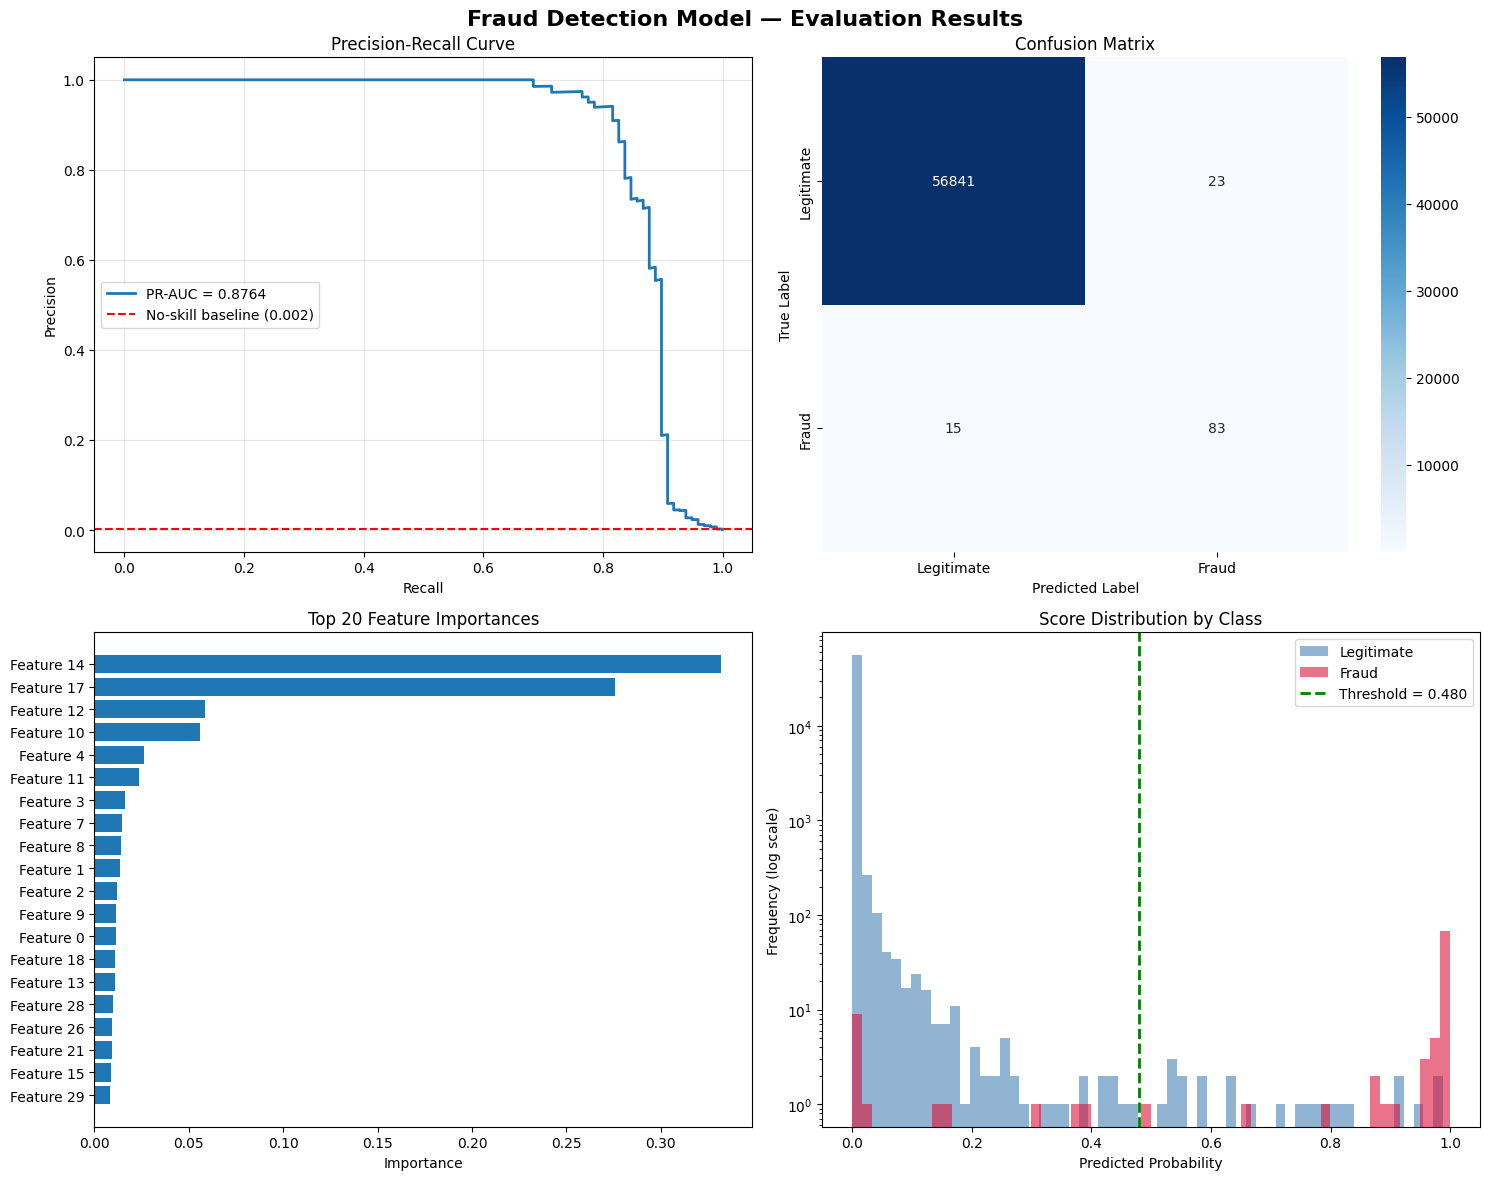

In [37]:
# ============================================================
# MAIN PIPELINE
# ============================================================

# ----------------------------------------------------------
# STEP 2 — Instantiate model
# USE_SMOTE=False: at 500:1 imbalance, scale_pos_weight outperforms SMOTE
# ----------------------------------------------------------
fraud_model = FraudDetectionModel(
    use_smote=USE_SMOTE,
    smote_sampling_strategy=SMOTE_RATIO,
)

# ----------------------------------------------------------
# STEP 3 — Split FIRST on raw imbalanced data
# The test set is sealed here and never touched again.
# ----------------------------------------------------------
print("\n" + "=" * 60)
print("STEP 3 — Train / test split (preserving real class ratio)")
print("=" * 60)
X_train, X_test, y_train, y_test = fraud_model.prepare_data(X, y)

# Carve a validation set from training data for early stopping & threshold tuning
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.15, stratify=y_train, random_state=42
)

# ----------------------------------------------------------
# STEP 4 — Cross-validation on training data (generalisation check)
# ----------------------------------------------------------
print("\n" + "=" * 60)
print("STEP 4 — Cross-validation on training set")
print("=" * 60)
fraud_model.cross_validate(X_train, y_train, n_splits=5)

# ----------------------------------------------------------
# STEP 5 — Train (SMOTE applied inside, only on X_tr)
# ----------------------------------------------------------
print("\n" + "=" * 60)
print("STEP 5 — Training")
print("=" * 60)
fraud_model.train(X_tr, y_tr, X_val=X_val, y_val=y_val)

# ----------------------------------------------------------
# STEP 6 — Threshold tuning on validation set (NOT test set)
# ----------------------------------------------------------
print("\n" + "=" * 60)
print("STEP 6 — Threshold optimisation (on validation set)")
print("=" * 60)
fraud_model.optimize_threshold(X_val, y_val, metric="f1") # Changed from "f2" to "f1"

# ----------------------------------------------------------
# STEP 7 — Final evaluation with train vs test comparison
# ----------------------------------------------------------
print("\n" + "=" * 60)
print("STEP 7 — Final evaluation")
print("=" * 60)
results = fraud_model.evaluate(X_test, y_test, X_train=X_train, y_train=y_train)


proba_test = fraud_model.model.predict_proba(X_test)[:, 1]
fraud_mask = y_test == 1
missed_mask = (y_test == 1) & (proba_test < fraud_model.best_threshold)

print("Missed fraud probability scores:")
print(sorted(proba_test[missed_mask]))
print("\nCaught fraud probability scores:")
print(sorted(proba_test[fraud_mask & ~missed_mask]))

# ----------------------------------------------------------
# STEP 8 — Plots & save
# ----------------------------------------------------------
fraud_model.plot_results(X_test, y_test)
fraud_model.save_model()

print("\n" + "=" * 60)
print("Pipeline complete!")
print("=" * 60)
